## Prerequisite: Install BorutaPy by hand
Otherwise the conda packages out there want to install py3.6, which MESS isn't ready for yet :(

In [3]:
%%bash
cd /home/isaac/Continuosity/MESS/util/
git clone https://github.com/scikit-learn-contrib/boruta_py
cd boruta_py
pip install .


In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib inline
import ipyparallel as ipp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import itertools

import MESS

from boruta import BorutaPy
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline
from IPython.display import display


## Set some pandas options to show the full rows and columns of a DF
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

## Where do the simulation outputs live. Load them and look at a couple
analysis_dir = "/home/isaac/Continuosity/MESS/analysis/full-parameter-estimation/"
sim_df = pd.read_csv("{}/SIMOUT.txt".format(analysis_dir), sep="\t", header=0)
## Legacy code. Drop in case any values are nan or inf
print(len(sim_df))

2983


## Load weevil data for mauritius and reunion and get summary stats

In [2]:
m_df = pd.read_csv("/home/isaac/SGD_empirical/empirical_weevils/mauritius.dat", header=0, index_col=0)
r_df = pd.read_csv("/home/isaac/SGD_empirical/empirical_weevils/reunion.dat", header=0)
print(len(m_df), len(r_df))
print(np.sum(m_df["abundance"]))
print(np.sum(r_df["abundance"]))
display(m_df[:2])
display(r_df[:2])
m_ss = MESS.stats.calculate_sumstats(diversity_df=m_df)
r_ss = MESS.stats.calculate_sumstats(diversity_df=r_df)
display(m_ss)
display(r_ss)


(26, 27)
343.0
539.0


,pi,abundance
Cratopopsis_impressus,0.043741,4.0
Cratopopsis_mauritianus,0.002413,5.0


,Unnamed: 0,pi,abundance
0,Cratopopsis_alluaudi,0.019174,12.0
1,Cratopopsis_antiquus,0.017928,11.0


,S,abund_h1,abund_h2,abund_h3,abund_h4,pi_h1,pi_h2,pi_h3,pi_h4,mean_pi,std_pi,skewness_pi,kurtosis_pi,median_pi,iqr_pi,trees,abundance_pi_cor,SGD_0,SGD_1,SGD_2,SGD_3,SGD_4,SGD_5,SGD_6,SGD_7,SGD_8,SGD_9
0,26,15.551964,11.553471,9.749593,8.776689,16.525113,13.293617,11.35714,10.189882,0.022862,0.022351,1.469762,1.797334,0.020936,0.019995,0,0.503694,10,2,6,4,1,0,1,0,1,1


,S,abund_h1,abund_h2,abund_h3,abund_h4,pi_h1,pi_h2,pi_h3,pi_h4,mean_pi,std_pi,skewness_pi,kurtosis_pi,median_pi,iqr_pi,trees,abundance_pi_cor,SGD_0,SGD_1,SGD_2,SGD_3,SGD_4,SGD_5,SGD_6,SGD_7,SGD_8,SGD_9
0,27,12.342967,8.390983,7.234338,6.756258,17.708787,14.927681,13.310007,12.280974,0.025299,0.022751,0.947168,0.086781,0.019174,0.028364,0,0.638078,7,4,3,3,4,2,1,0,0,3


## Select simulation features to correspond to empirical data

In [45]:
## Parameters to estimate
features = m_ss.columns
targets = ["alpha", "J_m", "ecological_strength", "m", "speciation_prob", "_lambda"]

X = sim_df[features]
y = sim_df[targets]
y[:20]

,alpha,J_m,ecological_strength,m,speciation_prob,_lambda
0,2167,1194608,1.90849,0.00391,0.00096,0.764
1,1338,2535024,5.44232,0.00922,0.00075,0.207
2,1497,2524185,8.82816,0.00120,0.00046,0.299
3,2278,4892071,8.94387,0.00583,0.00058,0.326
4,4907,1318554,7.11186,0.00235,0.00099,0.980
5,875,1754213,6.58295,0.00990,0.00065,0.605
6,3740,4548798,6.16385,0.00880,0.00055,0.484
7,1145,4743747,8.52638,0.00134,0.00029,0.551
8,4895,3618925,3.96957,0.00602,0.00018,0.629
9,2639,4331250,4.14036,0.00494,0.00033,0.751


## Select only relevant features
[Boruta all relevant feature selection](http://danielhomola.com/2015/05/08/borutapy-an-all-relevant-feature-selection-method/) [(Github)](https://github.com/scikit-learn-contrib/boruta_py)

In [41]:
def feature_selection(X, y, verbose=False):
    tmpX = X.values
    tmpy = y.values
    #rf = RandomForestRegressor(*{'warm_start': False, 'oob_score': False, 'n_jobs': -1, 'min_impurity_decrease': 0.0, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': False, 'min_samples_leaf': 4, 'n_estimators': 600, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mse', 'random_state': None, 'min_impurity_split': None, 'max_features': 'auto', 'max_depth': 60})
    rf = RandomForestRegressor(n_jobs=-1, n_estimators=600, max_depth=5)

    # define Boruta feature selection method
    feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=1)
    np.warnings.filterwarnings('ignore')
    feat_selector.fit(tmpX, tmpy)

    # check ranking of features
    if verbose: print(feat_selector.ranking_)
    X_filtered = feat_selector.transform(tmpX)
    ## Use feat_selector.support_weak_ to include more variables
    X_filtered = pd.DataFrame(X_filtered, columns = X.columns[feat_selector.support_])
    return X_filtered

for target in ["_lambda"]:#targets:
    X_filtered = feature_selection(X, y[target])
    print(target, X_filtered.columns)


NameError: name 'feat_selector' is not defined

In [6]:
## Split the data
print(X.shape, X_filtered.shape, y.shape)
Xtrain, Xtest, ytrain, ytest = train_test_split(X_filtered, y)
Xtrain[:2]

((11974, 27), (11974, 9), (11974, 6))


,S,abund_h1,abund_h2,abund_h3,abund_h4,mean_pi,std_pi,iqr_pi,abundance_pi_cor
10070,22.0,9.28963,7.29799,6.48516,6.00599,0.00065,0.00094,0.00105,0.51113
285,16.0,3.28456,2.04127,1.76550,1.66198,0.00007,0.00014,0.00000,0.68445


## Find best RF parameter values given our data

In [46]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

## Randomly search 100 different parameter combinations and take the
## one that reduces CV error
rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(),\
                               param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=0, n_jobs = -1)
rf_random.fit(Xtrain, ytrain)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'min_samples_split': [2, 5, 10], 'bootstrap': [True, False], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

## How good is our model on simulated data?
It's okay actually.

In [47]:
model = rf_random.best_estimator_
scores = cross_val_score(model, X, y, cv=5)
scores

array([ 0.00263291, -0.00120313, -0.00191964, -0.00244868, -0.00646401])

## Train model on full simulated data (maybe this is unnecessary)
Doesn't change the outcome much to retrain the model using all the simulated data.
```
## Mauritius ypred w/o retraining on the full data
array([[6.53216976e+03, 2.41468557e-04, 3.74642894e-03]])

## Mauritius ypred after retraining on the full data
array([[6.50993991e+03, 2.40522839e-04, 3.98148285e-03]])
```

## Use the trained model to predict the params for the real data

In [52]:
m_ss = m_ss[X_filtered.columns]
r_ss = r_ss[X_filtered.columns]

#display(pd.DataFrame(model.feature_importances_, index=X_filtered.columns).T)
m_ypred = model.predict(m_ss)
r_ypred = model.predict(r_ss)
display(pd.DataFrame(m_ypred, columns=targets))
display(pd.DataFrame(r_ypred, columns=targets))

ValueError: Number of features of the model must match the input. Model n_features is 9 and input n_features is 18 

## Get fancy. Get predictions from each of the trees in the forest.
This is an effort to try to obtain some kind of CI on the estimates. I guess the logic here is you're using all the trees including the good ones and the crappy ones, so looking at the distribution of estimates isn't really informative. The rf.predict() function just returns the mean of all these.

In [22]:
m_predictions = np.array([x.predict(m_ss)[0] for x in model.estimators_])
r_predictions = np.array([x.predict(r_ss)[0] for x in model.estimators_])

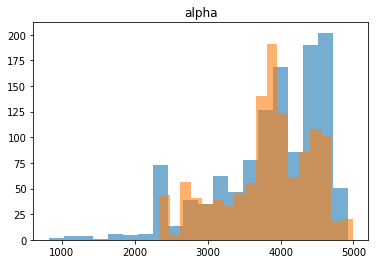

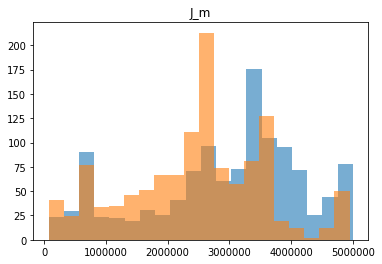

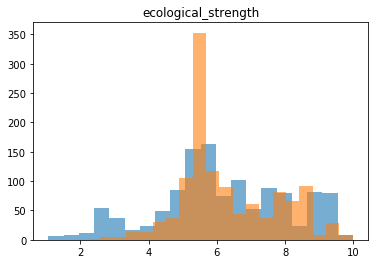

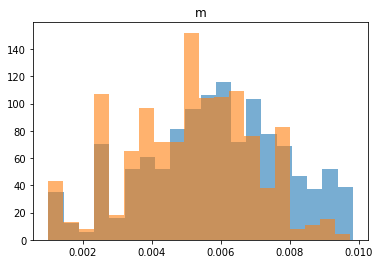

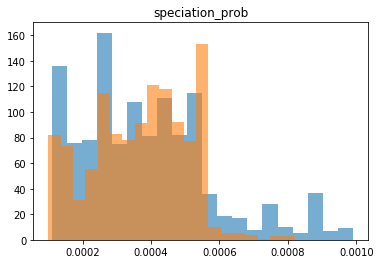

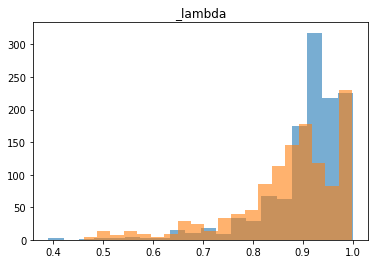

In [25]:
for i, t in enumerate(targets):
    fig, ax = plt.subplots()
    #print(np.mean(m_predictions[:, i]))
    _, _, _ = ax.hist(m_predictions[:, i], alpha=0.6, bins=20)
    #print(np.mean(r_predictions[:, i]))
    _, _, _ = ax.hist(r_predictions[:, i], alpha=0.6, bins=20)
    ax.set_title(t)